In [28]:
import Fountain
import scanpy as sc
import episcanpy as epi
import numpy as np
import sklearn
import pandas as pd 
import torch
from Fountain.data import create_dataloader,create_batchind_dict
#import Fountain.layer
from Fountain.fountain import Fountain
from Fountain.utils import cluster_evaluation
from Fountain.utils import overcorrection_score
import scib
import matplotlib.pyplot as plt
import scipy
import os

# Data preprocessing

The example data for batch correction can be download at [here](https://drive.google.com/file/d/1qwKP1xzYVs5rEGRJPU_NJga2Gl0qSTv5/view?usp=sharing
).

In [29]:
adata=sc.read('/data/cabins/chenshengquan/scCAS221012/mouse_brain.h5ad')

In [30]:
adata

AnnData object with n_obs × n_vars = 13671 × 479127
    obs: 'batch', 'cell_type', 'cell_type_raw', 'test_type'
    var: 'peak'

In [31]:
binary=True
fpeak=0.04
if binary: epi.pp.binarize(adata)
epi.pp.filter_features(adata, min_cells=np.ceil(fpeak*adata.shape[0]))


In [32]:
adata

AnnData object with n_obs × n_vars = 13671 × 22320
    obs: 'batch', 'cell_type', 'cell_type_raw', 'test_type'
    var: 'peak', 'n_cells'

#  Model initialization

In [33]:
batchind_dict=create_batchind_dict(adata,batch_name='batch')
batchsize=min(128*len(batchind_dict),1024)
dataloader=create_dataloader(adata,batch_size=batchsize,batchind_dict=batchind_dict,batch_name='batch',num_worker=4,droplast=True)
enc=[['fc', 1024, '', 'gelu'],['fc', 256, '', 'gelu'],['fc', 16, '', '']]
dec=[['fc', adata.X.shape[1], '', '']]
#early_stopping= EarlyStopping_simple(patience=30)
early_stopping= None
device='cuda:0'

In [34]:
model=Fountain(adata,enc,dec, n_domain=len(create_batchind_dict(adata,batch_name='batch')),batch_name='batch')

# Model training

In [35]:
model.train(            
            dataloader,             
            lambda_mse=0.005, 
            lambda_Eigenvalue=0.5,
            eigenvalue_type='mean',#'mean' or 'normal'
            max_iteration=30000,
            mid_iteration=3000,
            loss='Negative_multinomial',
            early_stopping=early_stopping,
            device=device, 
        )

Epochs: 100%|██████████| 567/567 [40:26<00:00,  4.28s/it, recon_loss=8751.464,kl_loss=33.670,mse_loss=18.928]


# Get batch corrected low-dimensional embedding

In [36]:
model.get_latent(adata,device=device,emb='fountain')

UMAP visualization

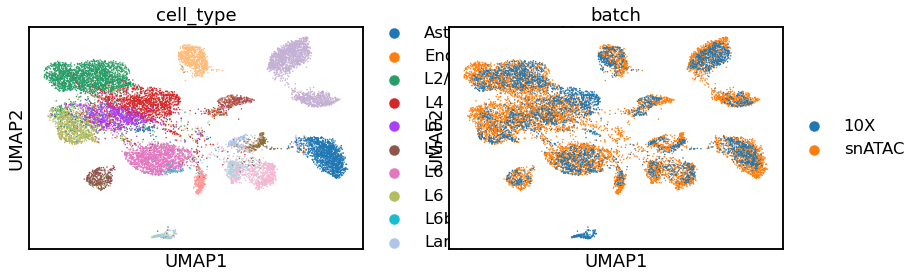

In [37]:
sc.pp.neighbors(adata, use_rep='fountain')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type','batch'])

Model evaluation. Here, we use AMI, ARI, and NMI as metrics to evaluate the clustering of the model,  iLISI_graph and Graph_connectivity as metrics to evaluate the batch correction effect of the model, and Overcorrection score as a metric to evaluate the ability of the model to prevent overcorrection from occurring.

In [11]:
epi.tl.leiden(adata, key_added='leiden')

AMI = cluster_evaluation(adata.obs,'cell_type','leiden')[0]
ARI = cluster_evaluation(adata.obs,'cell_type','leiden')[1]
NMI = cluster_evaluation(adata.obs,'cell_type','leiden')[2]
Graph_connectivity = scib.me.graph_connectivity(adata, label_key="cell_type")
iLISI_graph = scib.me.ilisi_graph(adata, batch_key="batch",type_="embed",  use_rep="fountain", scale=False)
overcorrection = overcorrection_score(adata.obsm["fountain"], adata.obs['cell_type'], n_neighbors=100, n_pools=100, n_samples_per_pool=100)


leiden
AMI:0.761	ARI:0.702	NMI:0.763	HOM:0.777	
leiden
AMI:0.761	ARI:0.702	NMI:0.763	HOM:0.777	
leiden
AMI:0.761	ARI:0.702	NMI:0.763	HOM:0.777	


# Generate batch-corrected and enhanced ATAC profiles in the original dimension

In [12]:
adata.layers['enhance']=model.enhance(adata,device='cuda:0',batch_name='batch')

UMAP plots colored by the sequencing depth of batch-corrected and enhanced ATAC profiles.

         Falling back to preprocessing with `sc.pp.pca` and default params.


<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

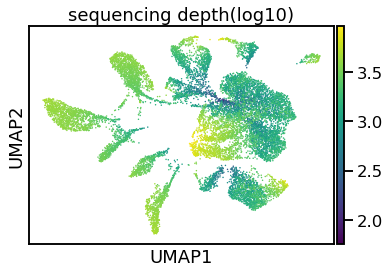

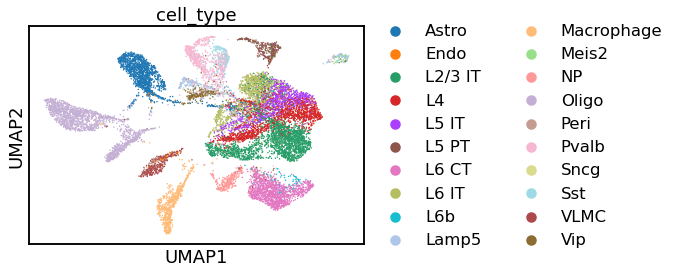

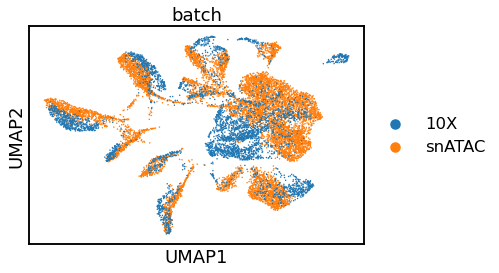

In [13]:
adata_en = adata.copy()
adata_en.X = adata_en.layers['enhance']
epi.pp.binarize(adata_en)

sc.pp.neighbors(adata_en, n_neighbors=15)
sc.tl.umap(adata_en)
count_sum_per_cell = adata_en.X.sum(axis=1)
adata_en.obs['sequencing depth'] = count_sum_per_cell
adata_en.obs['sequencing depth(log10)'] = np.log10(count_sum_per_cell)
sc.pl.umap(adata_en, color=["sequencing depth(log10)"],show=False,color_map='viridis')
sc.pl.umap(adata_en, color=['cell_type'],show=False,color_map='viridis')
sc.pl.umap(adata_en, color=['batch'],show=False,color_map='viridis')


UMAP plots colored by the sequencing depth of raw ATAC profiles. In order to provide a clearer distribution of sequencing depth, we plotted the UMAP based on the low dimensional representation of the corrected data and colored it using the sequencing depth of the raw data.

<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

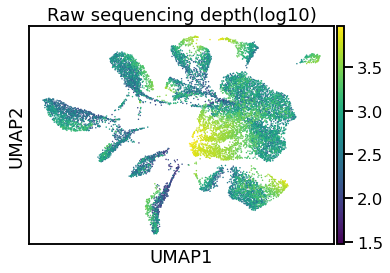

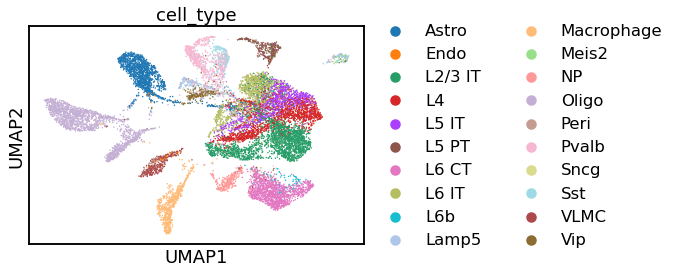

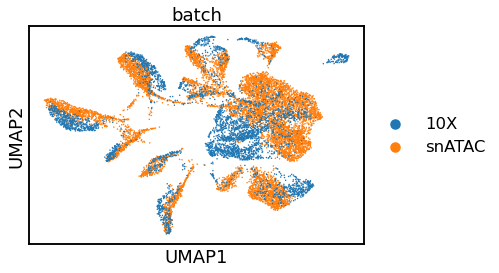

In [19]:
adata_raw=sc.read('/data/cabins/chenshengquan/scCAS221012/mouse_brain.h5ad')
binary=True
fpeak=0.04
if binary: epi.pp.binarize(adata_raw)
epi.pp.filter_features(adata_raw, min_cells=np.ceil(fpeak*adata_raw.shape[0]))
count_sum_per_cell_raw = adata_raw.X.sum(axis=1)

adata_en.obs['Raw sequencing depth'] = count_sum_per_cell_raw
adata_en.obs['Raw sequencing depth(log10)'] = np.log10(count_sum_per_cell_raw )
sc.pl.umap(adata_en, color=["Raw sequencing depth(log10)"],show=False,color_map='viridis')
sc.pl.umap(adata_en, color=['cell_type'],show=False,color_map='viridis')
sc.pl.umap(adata_en, color=['batch'],show=False,color_map='viridis')

Heatmap of the count matrix of the Fountain-enhanced data for the differentially accessible peaks identified from the Fountain-enhanced dataset. 

In [15]:
from sklearn.preprocessing import Binarizer
adata_h = adata.copy()
adata_h.X = adata_h.layers['enhance']
def binarizer(count_matrix,threshold = 0):
    bn = Binarizer(threshold = threshold)
    count_matrix_bn = bn.fit_transform(count_matrix)
    return count_matrix_bn
adata_h.X = binarizer(adata_h.X)
sc.pp.normalize_total(adata_h, inplace=True)
labelorder = adata_h.obs["cell_type"].unique()
kwds={"standard_scale":"var"}

sc.tl.rank_genes_groups(adata_h, groupby="cell_type", method="wilcoxon")
adata_h.uns["rank_features_groups"]=adata_h.uns["rank_genes_groups"]


{'heatmap_ax': <Axes: >,
 'groupby_ax': <Axes: ylabel='cell_type'>,
 'gene_groups_ax': <Axes: >}

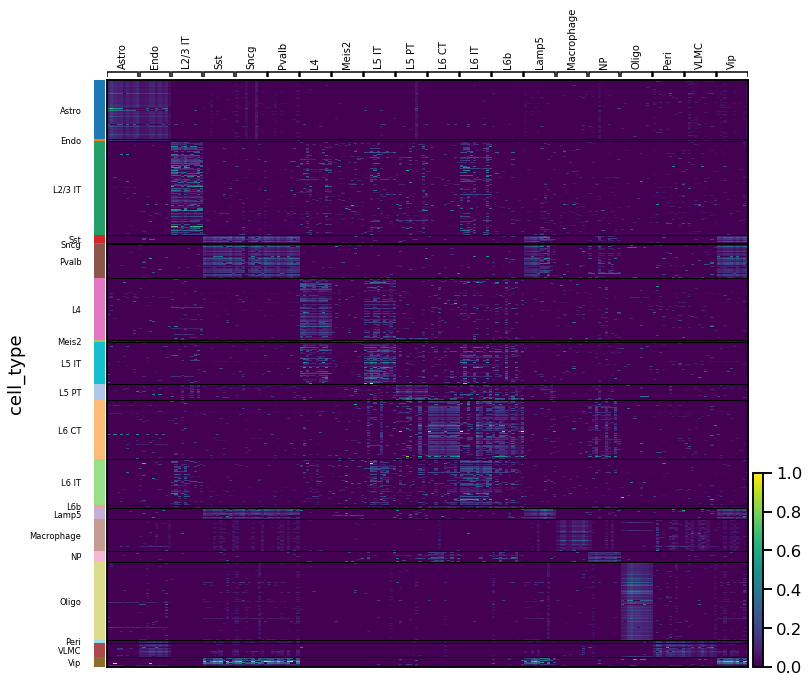

In [18]:
order =[
    'Astro','Endo','L2/3 IT','Sst','Sncg','Pvalb','L4','Meis2','L5 IT','L5 PT','L6 CT','L6 IT','L6b','Lamp5','Macrophage','NP','Oligo','Peri','VLMC','Vip'
]
adata_h.obs['cell_type'] = pd.Categorical(adata_h.obs['cell_type'], categories=order, ordered=True)

import matplotlib.pyplot as plt
cell_types = order

result = adata_h.uns['rank_features_groups']
names_array = result['names']
scores_array = result['scores']
pvals_array = result['pvals']
pvals_adj_array = result['pvals_adj']
logfoldchanges_array = result['logfoldchanges']

def reorder_recarray(recarray, rder):
    new_dtype = [(name, recarray.dtype[name]) for name in order]
    new_recarray = np.empty(recarray.shape, dtype=new_dtype)
    for name in order:
        new_recarray[name] = recarray[name]
    return new_recarray


result['names'] = reorder_recarray(names_array, order)
result['scores'] = reorder_recarray(scores_array, order)
result['pvals'] = reorder_recarray(pvals_array, order)
result['pvals_adj'] = reorder_recarray(pvals_adj_array, order)
result['logfoldchanges'] = reorder_recarray(logfoldchanges_array, order)
adata_h.uns['rank_features_groups']=result
groups =cell_types
markers = pd.DataFrame(
    {group +  key[:1]: result[key][group]
    for group in groups for key in ['names']}).head(10).T
markers = np.array(markers.values).reshape(1,-1)[0]
sc.pl.heatmap(adata_h, markers, groupby='cell_type',var_group_positions = [(0,9),(10,19),(20,29),(30,39),(40,49),(50,59),(60,69),(70,79),(80,89),(90,99),(100,109),(110,119),(120,129),(130,139),(140,149),(150,159),(160,169),(170,179),(180,189),(190,199)],var_group_labels = cell_types,standard_scale="var",figsize=(12, 11),show = False)

# Online integration

Data preprocessing

The example data for online integration can be download at [here](https://drive.google.com/file/d/1-ApKLvn9dc_Z4vE4nHJ0cFUAMTp2ra4c/view?usp=share_link).

In [39]:
adata_lung = sc.read('/home/sccasinteg/data/sccasinteg/hhy/data/GSE161381_lung.h5ad') 
fpeak = 0.04
binary=True
if binary: epi.pp.binarize(adata_lung)
epi.pp.filter_features(adata_lung, min_cells=np.ceil(fpeak*adata_lung.shape[0]))
adata_lung.obs["cell_type"] = adata_lung.obs["celltype"]
adata_lung.obs["batch"] = adata_lung.obs["orig.ident"]

Obtaining batches for training

In [40]:
Train_batch=['D032', 'D032-2', 'D088', 'D150', 'D231','D122','D139']
adata_train=adata_lung[adata_lung.obs['batch'].isin(Train_batch)].copy()

In [46]:
adata_train.obs["batch"] = adata_train.obs["batch"].astype('category')

Model initialization and model training

In [48]:
batchind_dict=create_batchind_dict(adata_train,batch_name='batch')
batchsize=min(128*len(batchind_dict),1024)
dataloader=create_dataloader(adata_train,batch_size=batchsize,batchind_dict=batchind_dict,batch_name='batch',num_worker=4,droplast=True)
enc=[['fc', 1024, '', 'gelu'],['fc', 256, '', 'gelu'],['fc', 16, '', '']]
dec=[['fc', 256, '', 'gelu'],['fc', adata_train.X.shape[1], '', '']]
#early_stopping= EarlyStopping_simple(patience=30)
early_stopping= None
device='cuda:0'
model=Fountain(adata_train,enc,dec, n_domain=len(create_batchind_dict(adata_train,batch_name='batch')),batch_name='batch')

In [49]:
model.train(            
            dataloader,             
            lambda_mse=0.005, 
            lambda_Eigenvalue=0.5,
            eigenvalue_type='mean',#'mean' or 'normal'
            max_iteration=30000,
            mid_iteration=3000,
            loss='Negative_multinomial',
            early_stopping=early_stopping,
            device=device, 
        )

Epochs: 100%|██████████| 484/484 [1:36:02<00:00, 11.91s/it, recon_loss=26703.421,kl_loss=131.820,mse_loss=44.284]


In [64]:
adata_lung

AnnData object with n_obs × n_vars = 90980 × 15288
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'cell', 'UMAP1', 'UMAP2', 'celltype', 'cell_type', 'batch'
    var: 'count', 'percentile', 'var.features', 'var.features.rank', 'RNA_features', 'n_cells'
    obsm: 'X_lsi', 'X_umap'
    varm: 'LSI'
    layers: 'RNA'

Project the whole dataset to the shared latent space

In [69]:
model.get_latent(adata_lung,device=device,emb='online')

In [71]:
adata_lung.obsm['online']

array([[-0.03986874,  0.21407221,  0.75934356, ..., -0.3462717 ,
         0.66500384, -0.22958353],
       [ 0.030878  ,  0.11676238,  0.24626058, ...,  0.7586019 ,
        -0.33595595,  0.23455933],
       [ 0.0810124 ,  0.1016383 ,  0.92962927, ..., -0.33242226,
         0.81061   , -0.2705533 ],
       ...,
       [-0.05115566, -0.0235792 ,  0.94136685, ..., -0.04930883,
         1.0071027 , -0.22532456],
       [ 0.39125323, -0.63432086,  0.96290475, ..., -0.8846028 ,
         1.3810253 ,  0.45344412],
       [ 0.483725  , -0.87219673,  0.5085579 , ...,  0.5165743 ,
        -0.86052054,  0.9109811 ]], dtype=float32)

online integration

In [72]:
colors = ['#FFFF00', '#1CE6FF', '#FF34FF', '#FF4A46', '#008941', '#006FA6', '#A30059', '#FFDBE5', '#7A4900', '#0000A6',
                  '#63FFAC', '#B79762', '#004D43', '#8FB0FF', '#997D87', '#5A0007', '#809693', '#6A3A4C', '#1B4400', '#4FC601',
                  '#3B5DFF', '#4A3B53', '#FF2F80', '#61615A', '#BA0900', '#6B7900', '#00C2A0', '#FFAA92', '#FF90C9', '#B903AA',
                  '#D16100', '#DDEFFF', '#000035', '#7B4F4B', '#A1C299', '#300018', '#0AA6D8', '#013349', '#00846F', '#372101',
                  '#FFB500', '#C2FFED', '#A079BF', '#CC0744', '#C0B9B2', '#C2FF99', '#001E09']
Train=['D032', 'D032-2', 'D088', 'D150', 'D231', 'D139', 'D122']
Not_train=[ 'D046', 'D062',  'D110','D175']
cell_types = adata_train.obs['cell_type'].unique()
batch= adata_train.obs['batch'].unique()
# map each cell type to a color
color_map = dict(zip(cell_types, colors[:len(cell_types)]))
color_map2 = dict(zip(batch, colors[:len(batch)]))

In [74]:
#The path where you saved the file
save_folder='/home/sccasinteg/data/Fountain_online'
os.path.join(save_folder, 'online_batch.pdf')

'/home/sccasinteg/data/Fountain_online/online_batch.pdf'

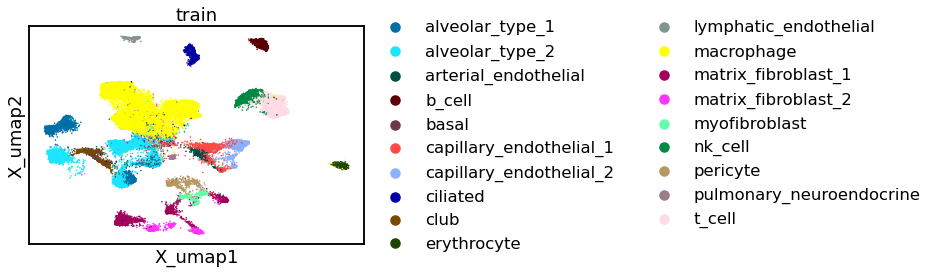

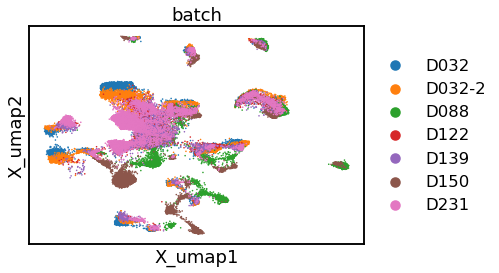

In [76]:

adata_train.obs['train'] = adata_train.obs['cell_type'].astype(str)
adata_train.obs['train_batch'] = adata_train.obs['batch'].astype(str)
sc.pl.embedding(adata_train, color='train', basis='X_umap',   palette=color_map, size=10, save= 'online_cell_type_fountain.pdf',
                   legend_loc='right margin', legend_fontsize=None, legend_fontweight='bold', show=True)
sc.pl.embedding(adata_train, color='batch', basis='X_umap',   palette=None, size=10, save= 'online_batch_fountain.pdf',
                   legend_loc='right margin', legend_fontsize=None, legend_fontweight='bold', show=True)

In [79]:
from Fountain.plot import embedding
for i in Not_train:
    batch_list = Train.copy()
    batch_list.append(i)
    adata_plot=adata_lung[adata_lung.obs['batch'].isin(batch_list)].copy()
    embedding(
        adata_plot, 
        color='cell_type', 
        color_map=color_map, 
        groupby='batch', 
        groups=[i], 
        cond2=None, 
        v2=None, 
        save='online_batch_fountain'+i+'.pdf', 
        legend_loc='right margin', 
        legend_fontsize=None, 
        legend_fontweight='bold', 
        sep='_', 
        basis='X_umap',
        size=10,
        show=False,
    )

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
